In [6]:
import os
print(os.getcwd())


/Users/christinayi


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# For computing evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [8]:
# Load the dataset (ensure the CSV file is in your working directory)
df = pd.read_csv("IMDB Dataset.csv")

# Inspect the first few rows
print(df.head())
print("Dataset shape:", df.shape)

# The dataset has two columns: 'review' and 'sentiment'.
# Convert sentiment labels to binary values: positive -> 1, negative -> 0.
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Check the distribution of sentiment classes
print(df['sentiment'].value_counts())

# Split the dataset evenly: 50,000 reviews into 25,000 for training and 25,000 for testing.
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42, shuffle=True)

print("Training samples:", train_df.shape[0])
print("Testing samples:", test_df.shape[0])


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Dataset shape: (50000, 2)
sentiment
1    25000
0    25000
Name: count, dtype: int64
Training samples: 25000
Testing samples: 25000


In [9]:
# Set parameters for tokenization and padding
max_features = 10000  # Consider only the top 10,000 words
max_len = 500         # Pad/truncate reviews to 500 tokens

# Create the tokenizer and fit on the training reviews
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_df['review'])

# Convert text reviews to sequences of integers
x_train_seq = tokenizer.texts_to_sequences(train_df['review'])
x_test_seq = tokenizer.texts_to_sequences(test_df['review'])

# Pad sequences so that they all have the same length
x_train = pad_sequences(x_train_seq, maxlen=max_len)
x_test = pad_sequences(x_test_seq, maxlen=max_len)

# Get the labels as numpy arrays
y_train = train_df['sentiment'].values
y_test = test_df['sentiment'].values

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)


Shape of x_train: (25000, 500)
Shape of x_test: (25000, 500)


In [10]:
# Build a sequential model
model = keras.models.Sequential([
    layers.Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
    layers.LSTM(64),  # LSTM layer with 64 units
    layers.Dense(1, activation='sigmoid')  # Final output for binary classification
])

# Compile the model with appropriate loss and optimizer
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()


/Users/christinayi/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
batch_size = 64
epochs = 5  # You can experiment with more epochs if needed

history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,  # Use 20% of the training data as validation
    verbose=1
)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 165ms/step - accuracy: 0.6877 - loss: 0.5611 - val_accuracy: 0.8476 - val_loss: 0.3568
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 170ms/step - accuracy: 0.8815 - loss: 0.2896 - val_accuracy: 0.8654 - val_loss: 0.3116
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 169ms/step - accuracy: 0.9173 - loss: 0.2200 - val_accuracy: 0.8654 - val_loss: 0.3341
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 166ms/step - accuracy: 0.9038 - loss: 0.2499 - val_accuracy: 0.8628 - val_loss: 0.3759
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 168ms/step - accuracy: 0.9264 - loss: 0.1908 - val_accuracy: 0.8668 - val_loss: 0.3553


In [12]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print(f"\nFinal Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

# Get model predictions (as probabilities) and convert to binary labels using a threshold of 0.5
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

# Calculate additional metrics using sklearn
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nAccuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.8723 - loss: 0.3452

Final Test Loss: 0.3485
Final Test Accuracy: 87.19%
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step

Accuracy:  87.19%
Precision: 0.8747
Recall:    0.8686
F1 Score:  0.8716


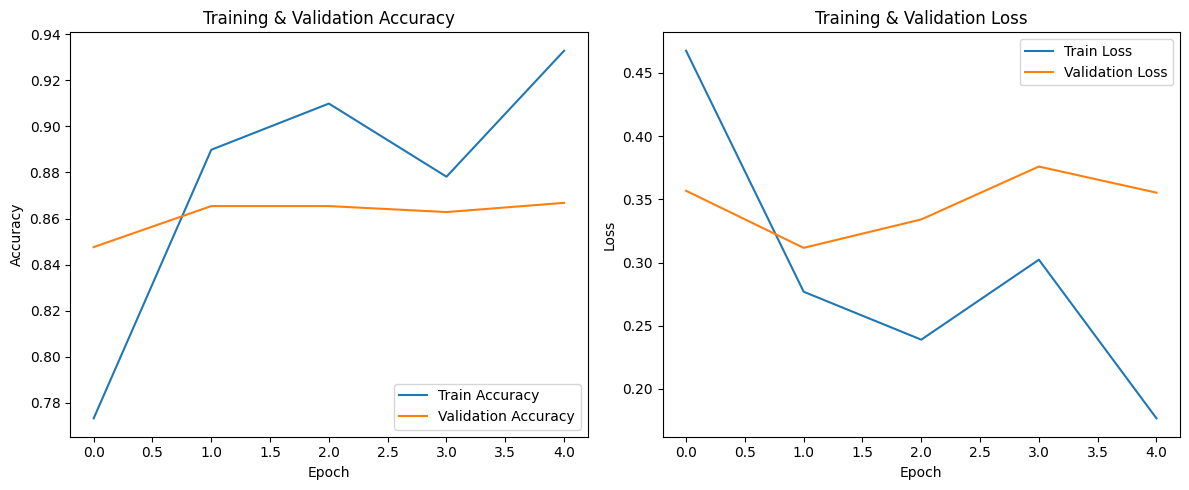

In [13]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
